In [3]:
# Визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["axes.titlesize"] = "large"

In [5]:
# Общеe

import os
import tqdm
import pathlib
import numpy as np
import pandas as pd

In [6]:
# Sklearn
from sklearn.metrics import f1_score, classification_report

# PyTorch etc.
import cv2
import tensorflow as tf
import tensorflow_hub as hub

2023-05-29 21:43:07.887486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 21:43:08.747407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-warning">
Не забудьте заменить <tt>DATA_DIR</tt> на имя локальной директории, в которую сохранили файлы.
</div>

In [18]:
DATA_DIR = pathlib.Path("../data/")
CLASSES = ["bridge_down", "bridge_up", "no_action", "train_in_out"]
RS = 3984765

# Загрузка данных

Видеоролики из тренировочного набора размещены в директориях, названных по имени класса:

```
dataset/
└── train
     ├── bridge_down
     │   ├── 01531ae3db6e8494.mp4
     │   ...
     │   └── fd39f2310c767b93.mp4
     ├── bridge_up
     │   ├── 009348946266095a.mp4
     │   ...
     │   └── fc176bebf46d3f43.mp4
     ├── no_action
     │   ├── 03b8033d6d547574.mp4
     │   ...
     │   └── fe75e1f7038e4fa8.mp4
     └── train_in_out
          ├── 01f23640259240cf.mp4
          ...
          └── fe8f774e99637f63.mp4
```

In [37]:
train_clips = sum([list(DATA_DIR.joinpath("train", c).glob("*.mp4")) for c in CLASSES], [])
train_clips = pd.DataFrame([clip.parts[-2:] for clip in train_clips], columns=["label", "fname"])

train_clips.head()

,label,fname
0,bridge_down,67f2ef6e74a93504.mp4
1,bridge_down,b9badc8dd567155f.mp4
2,bridge_down,88c00402cdad6b36.mp4
3,bridge_down,d606865a8dce4179.mp4
4,bridge_down,ea1bf78e20cd4c63.mp4


In [38]:
train_clips.label.value_counts()

bridge_down     306
bridge_up        75
train_in_out     66
no_action        49
Name: label, dtype: int64

Работать с роликами будем напрямую (для простоты настройки окружения, например, не нужно устанавливаться PyAV):

In [14]:
def read_clip(odir: pathlib.Path, fname: str, start: int = 0, transposed: bool = True):
    """Прочесть ролик в массив."""

    cpr = cv2.VideoCapture(odir.joinpath(fname).as_posix())
    has_frame = True
    frames = []

    while has_frame:
        has_frame, frame = cpr.read()
        if has_frame:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if transposed:
                frame = np.moveaxis(frame, -1, 0).copy()

            frames.append(frame)
    cpr.release()
    return np.array(frames)[start:]

In [19]:
sample_clip = train_clips.sample(1, random_state=RS).iloc[0]
clip = read_clip(DATA_DIR.joinpath("train", sample_clip.label), sample_clip.fname, transposed=False)

In [23]:
clip.shape

(197, 240, 320, 3)

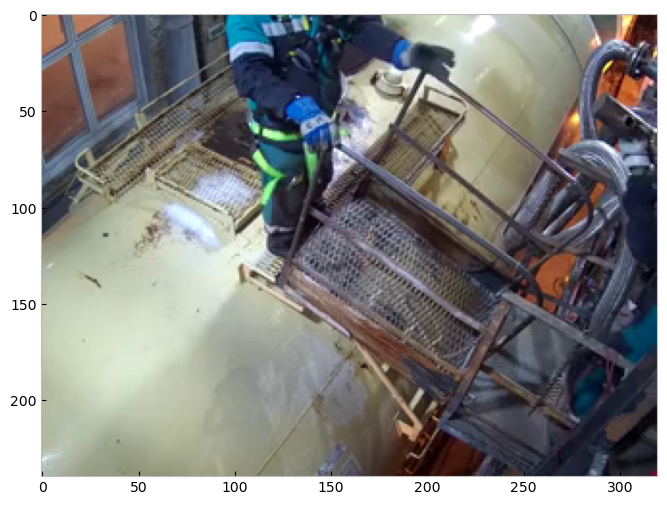

In [22]:
plt.figure(figsize=(8, 6))
plt.imshow(clip[1])
plt.grid(False)

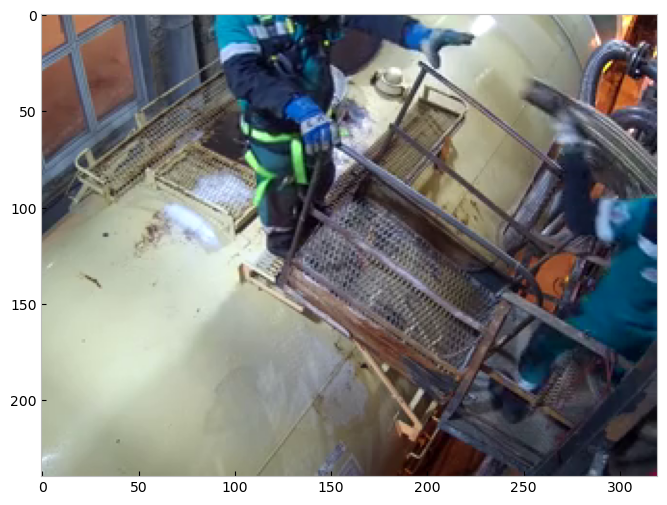

In [21]:
plt.figure(figsize=(8,6))
plt.imshow(clip[15])
plt.grid(False)

In [39]:
clip = read_clip(DATA_DIR.joinpath("train", sample_clip.label), sample_clip.fname, transposed=False)

# Преобразование с помощью претренированной модели

Мы используем очень простой подход:

- с помощью претренированной модели извлечём признаки для каждого кадра,
- посчитаем средняя значение для всего ролика,
- натренируем простую модель на полученных признаках.

Для извлечения признаков используем какую-либо из моделей, доступных в TensorFlow Hub. Обращаем внимание, что эта модель не даёт каких-то существенных значений F1, заведомо не обобщается и приведена для примера.

Это рекомендуемый способ (вместе с `launch.json`, см. ниже): так вы избежите необходимости грузить веса вручную. Загрузить веса претренированных моделей при работе контейнера не получится, поскольку он не будет иметь доступа к сети.

Для ускорения будет уменьшать изображения до `96 x 96`:

In [43]:
fts_extract = tf.keras.Sequential([
    tf.keras.layers.Resizing(96, 96, interpolation="bilinear"),
    tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/5", trainable=False)
])
fts_extract.build([None, 240, 320, 3])

2023-05-29 21:51:38.407626: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Вариант для PyTorch будет выглядеть иначе (на примере [ShuffleNet](https://pytorch.org/vision/stable/models/shufflenetv2.html)):

```python
weights = models.ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
model = models.shufflenet_v2_x0_5(weights=weights, progress=True)

summary(model,
        input_size=(32, 3, 224, 224),
        col_width=25,
        col_names=["input_size", "output_size", "trainable"])
```

Для этого необходимо добавить импорты:

```python
import torch
import torchvision
from torchvision import models, transforms
from torchinfo import summary
```

Кроме того, к изображениям необходимо применить преобразование иначе:
```python
transform = weights.transforms()
clip_t = torch.Tensor(clip[15] / 255)
transform(clip_t)
```

Посмотрим на пример признаков:

In [44]:
features_f = fts_extract(clip).numpy()

Получаем `1280` признаков (как и ожидается от этой модели):

In [45]:
features_f.shape

(197, 1280)

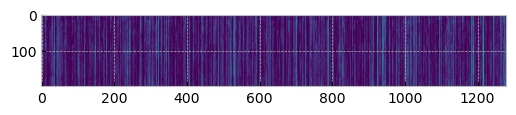

In [46]:
plt.imshow(features_f)

# Вычисляем признаки

У нас всего 496 роликов, поэтому 1280 признаков нам не нужны (и избыточны). Однако и нормально провести dimensionality reduction при таком количестве признаков тоже непросто. Поэтому сделаем random projection:

In [47]:
train_clips

,label,fname
0,bridge_down,67f2ef6e74a93504.mp4
1,bridge_down,b9badc8dd567155f.mp4
2,bridge_down,88c00402cdad6b36.mp4
3,bridge_down,d606865a8dce4179.mp4
4,bridge_down,ea1bf78e20cd4c63.mp4
...,...,...
491,train_in_out,d2987e35db4635c9.mp4
492,train_in_out,4fca1d1c23743300.mp4
493,train_in_out,68c64df10445214a.mp4
494,train_in_out,2ce08918cccbf9d0.mp4


In [48]:
from sklearn.random_projection import GaussianRandomProjection

In [49]:
projector = GaussianRandomProjection(n_components=50, random_state=RS)
projector.fit(np.random.rand(10, 1280))

GaussianRandomProjection(n_components=50, random_state=3984765)

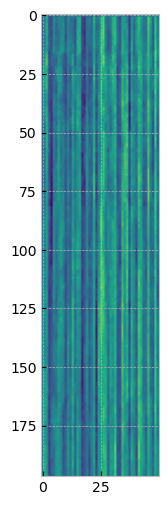

In [50]:
plt.imshow(projector.transform(features_f))

In [51]:
BS = 32

In [52]:
features = []

for ci, row in tqdm.tqdm(train_clips.iterrows(), total=train_clips.shape[0]):
    clip = read_clip(DATA_DIR.joinpath("train", row.label), row.fname, transposed=False)
    outputs = fts_extract(clip)
    features.append(projector.transform(outputs.numpy()).mean(axis=0))

100%|██████████| 496/496 [04:10<00:00,  1.98it/s]


In [54]:
features[0].shape

(50,)

In [56]:
features = np.vstack(features)

In [57]:
features.shape

(496, 50)

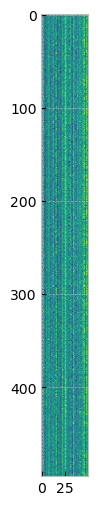

In [58]:
plt.imshow(features)

# Модель

Попробуем натренировать простую модель на этих признаках.

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [60]:
df = pd.DataFrame(features, index=train_clips.index, columns=[f"fts{i}" for i in range(features.shape[1])])

In [61]:
df = train_clips.join(df)

In [62]:
df_train, df_val = train_test_split(df, train_size=0.75, stratify=df.label)

In [63]:
df.filter(like="fts")

,fts0,fts1,fts2,fts3,fts4,fts5,fts6,fts7,fts8,fts9,...,fts40,fts41,fts42,fts43,fts44,fts45,fts46,fts47,fts48,fts49
0,-1.224784,3.815991,6.091563,-2.484534,-3.985608,3.462414,-3.157260,2.109485,-5.149494,-4.699189,...,-1.192971,5.514859,-0.753847,4.437098,0.244466,7.614017,-5.106569,-4.967801,2.752040,-3.729126
1,0.368921,4.072076,6.577665,-6.602164,-6.715771,-1.773834,-5.262852,-2.840307,4.653193,-3.964411,...,2.547471,4.270062,4.137734,3.907540,7.563846,9.478738,8.903163,1.663673,12.272475,1.325356
2,10.136932,-0.579897,2.118037,1.682864,0.434197,0.686122,-4.805888,-0.575005,4.010798,0.257419,...,7.875769,2.103914,-6.750867,1.436350,6.114092,5.566731,8.915426,-2.217239,2.578212,4.146105
3,-5.456013,-0.736286,-0.104545,-2.668796,-7.117635,-1.630724,1.707526,2.062340,3.191277,-0.518004,...,-1.979647,6.553640,3.908136,-3.961208,-3.535685,-1.258760,3.828356,-2.749084,1.907122,3.655615
4,0.735471,0.304766,1.195416,-2.817253,-6.898279,-3.801980,-2.363654,-4.251493,4.612290,0.626782,...,7.069150,2.949869,-0.860866,0.549796,1.737902,7.639138,3.098276,-1.614832,8.247894,2.760370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,-0.087215,-1.916832,3.043612,-0.290930,-4.711633,5.506099,1.433294,2.299524,7.851521,-6.044423,...,-10.132810,7.252392,-0.277758,-1.391572,5.060113,3.034022,2.380779,-9.139938,6.788568,0.380476
492,0.897698,-9.526299,3.030328,-8.516209,-9.160780,3.724240,-4.647885,1.054351,10.774222,5.271167,...,-8.864177,4.854414,0.056993,-1.035431,13.344665,7.703771,7.813394,-6.755346,1.224133,5.178733
493,5.828634,-6.874941,1.955431,-2.945677,-5.117517,0.016915,-3.810751,2.860327,3.224843,0.342218,...,3.567515,1.031917,-3.941269,0.677124,8.233745,5.052527,10.431741,0.329724,6.185830,3.808463
494,2.201074,-6.538151,6.416441,0.445301,-8.724634,-0.796180,-6.009477,-2.140704,6.248882,-0.671615,...,7.055159,2.577781,-1.668052,-2.152619,0.239334,3.580416,6.187910,1.201113,9.030313,2.254680


In [64]:
classifier = LogisticRegression(C=0.1, class_weight="balanced")
classifier.fit(df_train.filter(like="fts"), df_train.label)

LogisticRegression(C=0.1, class_weight='balanced')

In [65]:
train_preds = classifier.predict(df_train.filter(like="fts"))
val_preds = classifier.predict(df_val.filter(like="fts"))

In [66]:
print("TRAIN:")
print(classification_report(df_train.label, train_preds))

print("VAL:")
print(classification_report(df_val.label, val_preds))

TRAIN:
              precision    recall  f1-score   support

 bridge_down       1.00      0.94      0.97       230
   bridge_up       0.85      0.98      0.91        56
   no_action       0.95      1.00      0.97        37
train_in_out       0.90      0.96      0.93        49

    accuracy                           0.95       372
   macro avg       0.92      0.97      0.95       372
weighted avg       0.96      0.95      0.96       372

VAL:
              precision    recall  f1-score   support

 bridge_down       0.95      0.93      0.94        76
   bridge_up       0.63      0.89      0.74        19
   no_action       0.85      0.92      0.88        12
train_in_out       0.67      0.35      0.46        17

    accuracy                           0.85       124
   macro avg       0.77      0.77      0.76       124
weighted avg       0.85      0.85      0.84       124



In [68]:
from joblib import dump, load
dump(classifier, '../output/submit_baseline/classifier-v1.joblib')
dump(projector, '../output/submit_baseline/projector-v1.joblib')

['../output/submit_baseline/projector-v1.joblib']

Подготовим сабмит:

In [2]:
%%writefile predict.py

import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from joblib import load

PROJECTOR_FILE = pathlib.Path(__file__).parent.joinpath("projector-v1.joblib")
CLASSIFIER_FILE = pathlib.Path(__file__).parent.joinpath("classifier-v1.joblib")


def construct_model():
    fts_extract = tf.keras.Sequential([
        tf.keras.layers.Resizing(96, 96, interpolation="bilinear"),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/5", trainable=False)
    ])
    fts_extract.build([None, 240, 320, 3])
    return fts_extract


model = construct_model()
projector = load(PROJECTOR_FILE)
classifier = load(CLASSIFIER_FILE)


def predict(clip: np.ndarray):
    """Вычислить класс для этого клипа. Эта функция должна возвращать *имя* класса."""

    features = projector.transform(model(clip).numpy()).mean(axis=0, keepdims=True)
    return classifier.predict(features)[0]

Overwriting predict.py


Файл `launch.json` позволяет загрузить веса при сборке контейнера:

In [3]:
%%writefile launch.json
{
    "torch": ["shufflenet_v2_x0_5"],
    "tfhub": ["https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/5"],
    "transposed": false
}

Overwriting launch.json


В поле `torch` должен быть список (не более 3-х моделей) моделей из `torchvision.models.list_models()`. Для примера показана загрузка модели ShuffleNet.

В поле `tfhub` - список ссылок (не более 3-х) на любые валидные модели из TensorFlow Hub. Другие способы предзагрузки недоступны, поэтому веса придётся грузить вручную.

Поле `transposed` указывает, нужно ли подавать ролик в формате `H x W x C` (`false`, дефолтный вариант) или `C x H x W` (`true`).

# Дополнение

Аналогичную модель (в данном случае: c классификаторорм) можно получить иначе, с помощью Keras Applications:

In [39]:
def construct_model():
    feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3),
                                                          weights='imagenet')
    inputs = tf.keras.layers.Input((240, 320, 3))
    
    resized = tf.keras.layers.Resizing(96, 96, interpolation="bilinear")(inputs)
    rescaled = tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)(resized)
    outputs = feature_extractor(rescaled)

    return tf.keras.Model(inputs, outputs)

In [40]:
model = construct_model()

In [41]:
features_f = model(clip).numpy()

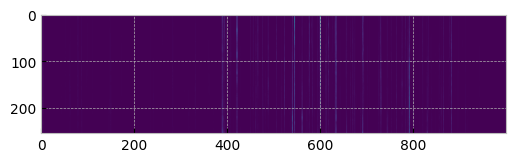

In [42]:
plt.imshow(features_f)

При этом веса придётся добавлять в сабмит и загружать их в модель из файла, посколько для Keras такого е простого способа предварительного скачивания весов.